In [ ]:
# This line of code is necessary to run before running the cell below. 
# Once this cell is run, you must press the 'Kernel' tab in the top left and then 'restart kernal and clear all outputs'.
# After that, return to this notebook file and you can now run the next block of code.
# import piplite
# await piplite.install("ipympl")

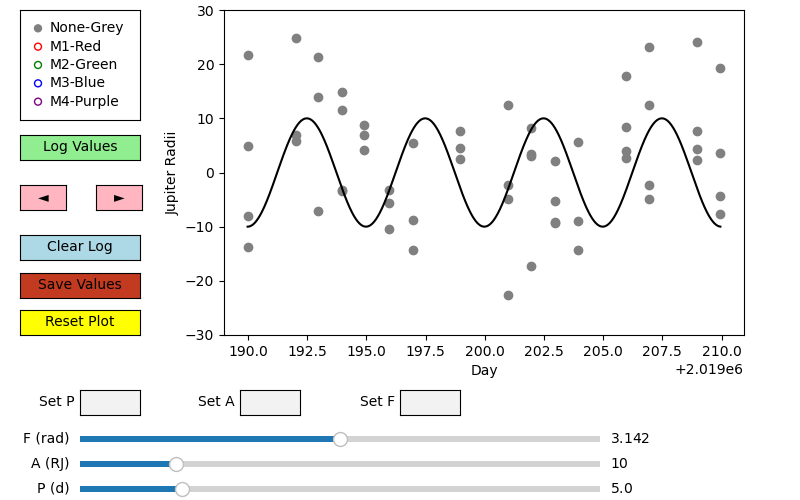

In [1]:
%matplotlib widget
# The above line is for use in Jupyter, including on syzygy.
# if you are running directly, such as on the command line, comment that first line

from astropy import units
from astropy.table import QTable
import matplotlib.pylab as plt
from matplotlib.widgets import Slider, Button, RadioButtons, TextBox
import numpy as np
import os
import time

au = getattr(units, 'au')
km = getattr(units, 'km')

pix = 4.289e-3
two_pi = 2 * np.pi
r_jup = 7.1492e4 * km

csv = np.loadtxt("pos.csv", skiprows=1, dtype=str, delimiter=',')

time_stamp = np.array([])
distance = np.array([])
uncertainty = np.array([])

log_data = list()
log_num = 0


for vals in csv:
    t = time.strptime(vals[0] + " " + vals[1],"%d-%b-%y %I:%M:%S %p")
    t_tmp = t[0] * 1000 + t[7] + (t[3] + t[4] / 60 + t[5] / 3600) / 24
    try:
        a = float(vals[7])
    except ValueError: 
        a = vals[7]
    try:
        b = float(vals[10])
    except ValueError:
        b = vals[10]
    try:
        c = float(vals[13])
    except ValueError:
        c = vals[13]
    try:
        d = float(vals[16])
    except ValueError:
        d = vals[16]
    distance_tmp = np.array([a, b, c, d])
    flag = distance_tmp != "NA"
    distance_tmp = distance_tmp[flag].astype(float)
    time_stamp = np.hstack((time_stamp, np.array([t_tmp for i in distance_tmp])))
    focal_length = float(vals[17])
    geo_distance = float(vals[19])
    distance_tmp *= (pix / focal_length * geo_distance * au / r_jup).decompose()
    distance = np.hstack((distance, distance_tmp))
    uncertainty = np.append(uncertainty, float(vals[18]) * pix / focal_length * 206265)
    

# Now let's see about finding periods and phases.

period_init = 5
period_min = 0.1
period_max = 25
delta_period = 0.05
phase_init = np.pi
phase_min = 0
phase_max = two_pi
amp_init = 10
amp_min = 1
amp_max = 50

fig = plt.figure(figsize=(8, 5), dpi=100)

# Now let's see about finding periods and phases.
curve_ax = plt.axes((0.28, 0.33, 0.65, 0.65))
slider_period_ax = plt.axes((0.1, 0.01, 0.65, 0.025))
slider_amp_ax = plt.axes((0.1, 0.06, 0.65, 0.025))
slider_phase_ax = plt.axes((0.1, 0.11, 0.65, 0.025))
input_period_ax = plt.axes((0.10, 0.17, 0.075, 0.05))
input_amp_ax = plt.axes((0.3, 0.17, 0.075, 0.05))
input_phase_ax = plt.axes((0.50, 0.17, 0.075, 0.05))

scat = list()
for num, i in enumerate(distance):
    data_point = curve_ax.scatter(time_stamp[num], i, c='grey', picker=True)
    scat.append(data_point)
curve_ax.set_ylim(-30, 30)
curve_ax.set_xlabel("Day")
curve_ax.set_ylabel('Jupiter Radii')
# l = curve_ax.legend(['M1-Red', 'M2-Green', 'M3-Blue', 'M4-Purple'], bbox_to_anchor=[-0.15, 0.99])

radio_ax = plt.axes((0.025, 0.76, 0.15, 0.22))
radio = RadioButtons(radio_ax, ('None-Grey', 'M1-Red', 'M2-Green', 'M3-Blue', 'M4-Purple'), radio_props={'facecolor': ['grey', 'red', 'green', 'blue', 'purple'], 'edgecolor': ['grey', 'red', 'green', 'blue', 'purple']}, active=0)


def color_func(label):
    print("Selected {}".format(label))

radio.on_clicked(color_func)

def on_pick(event):
    colour_label = radio.value_selected
    #print("Colour label is {}".format(colour_label))
    if colour_label == 'None-Grey':
        colour = [[0.5, 0.5, 0.5, 1]]
    elif colour_label == 'M1-Red':
        colour = [[1, 0, 0, 1]]
    elif colour_label == 'M2-Green':
        colour=[[0, 1, 0, 1]]
    elif colour_label == 'M3-Blue':
        colour = [[0, 0, 1, 1]]
    elif colour_label == 'M4-Purple':
        colour = [[1, 0, 1, 1]]
    else: 
        colour = [[0.5, 0.5, 0.5, 1]]
    event.artist.set_edgecolor(colour)
    event.artist.set_facecolor(colour)
    #c_edge=scat.get_edgecolors()
    #c_face=scat.get_facecolors()
    #c_edge[event.ind] = colour
    #c_face[event.ind] = colour
    #scat.set_edgecolor(c_edge)
    #scat.set_facecolor(c_face)
    fig.canvas.draw()

t = np.linspace(time_stamp[0],time_stamp[-1], 1000)

plt.axes(curve_ax)
cos_plot, = plt.plot(t, amp_init * np.cos((t - t[0]) * two_pi / period_init + phase_init), color='k')


period_slider = Slider(slider_period_ax, 'P (d)', period_min, period_max, valinit=period_init, valstep=delta_period)
amp_slider = Slider(slider_amp_ax, 'A (RJ)', amp_min, amp_max, valinit=amp_init)
phase_slider = Slider(slider_phase_ax, 'F (rad)', phase_min, phase_max, valinit=phase_init)
period_input = TextBox(input_period_ax, 'Set P ')
amp_input = TextBox(input_amp_ax, 'Set A ')
phase_input = TextBox(input_phase_ax, 'Set F ')


def update(val):
    period = period_slider.val
    amp = amp_slider.val
    phase = phase_slider.val
    cos_plot.set_ydata(amp * np.cos((t - t[0]) * two_pi / period + phase))
    fig.canvas.draw()


def text_sub_slide_period(val):
    period_slider.set_val(float(val))
    
    
def text_sub_slide_amp(val):
    amp_slider.set_val(float(val))
    
    
def text_sub_slide_phase(val):
    phase_slider.set_val(float(val))


period_slider.on_changed(update)
amp_slider.on_changed(update)
phase_slider.on_changed(update)

period_input.on_submit(text_sub_slide_period)
amp_input.on_submit(text_sub_slide_amp)
phase_input.on_submit(text_sub_slide_phase)

log_ax = plt.axes((0.025, 0.68, 0.15, 0.05))
button_log = Button(log_ax, 'Log Values', color='lightgreen', hovercolor='0.975')


def log(event):
    # Print the current log values to the plot window.
    global log_num, log_data
    max_index = len(log_data)-1
    slider_vals = [phase_slider.val, amp_slider.val, period_slider.val]
    if len(log_data) > 0 and log_data[max_index] == slider_vals:
        return
    else:
        for txt in fig.texts:
            txt.set_visible(False)
        log_data.append(slider_vals)
        log_num = (len(log_data)-1)
        fig.text(0.95,-0.395,'{0:.3f} \n{1:.3f} \n{2:.3f}'.format(slider_vals[0],
                                                                  slider_vals[1],
                                                                  slider_vals[2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=curve_ax.transAxes,
                 linespacing=2,
                 weight='bold')
        fig.text(0.95,-0.23,'Logged Potential\nSolution {}:'.format(log_num+1),
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=curve_ax.transAxes,
                 fontsize=8)
        # Print the current log values to the terminal.
        print("\nLogged Potential Solution:\
              \nPeriod: {} d\
              \nAmplitude: {} Jupiter Radii\
              \nPhase: {} rad".format(period_slider.val, amp_slider.val, phase_slider.val))
        fig.canvas.draw()

button_log.on_clicked(log)

# A button to clear the log separately of the plot.
clear_log_ax = plt.axes((0.025, 0.48, 0.15, 0.05))
button_clear_log=Button(clear_log_ax, 'Clear Log', color="lightblue", hovercolor='0.975')

def clear_log(event):
    global log_num, log_data
    for txt in fig.texts:
        txt.set_visible(False)
    log_data = list()
    log_num = 0
    fig.canvas.draw_idle() # Updates the canvas immediately.

button_clear_log.on_clicked(clear_log)



# Buttons to move forward and backward through the logged data.
prev_log_ax = plt.axes((0.025, 0.58, 0.057, 0.05))
button_prev_log=Button(prev_log_ax, '◄', color="lightpink", hovercolor='0.975')

def prev_log(event):
    global log_num, log_data
    if log_num == 0:
        return
    else:
        log_num -= 1
        p_data = log_data[log_num]
        for txt in fig.texts:
            txt.set_visible(False)
        fig.text(0.95,-0.395, '{0:.3f} \n{1:.3f} \n{2:.3f}'.format(p_data[0],
                                                                   p_data[1],
                                                                   p_data[2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=curve_ax.transAxes,
                 linespacing=2,
                 weight='bold')
        fig.text(0.95,-0.23,'Logged Potential\nSolution {}:'.format(log_num+1),
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=curve_ax.transAxes,
                 fontsize=8)
        fig.canvas.draw_idle()

button_prev_log.on_clicked(prev_log)


next_log_ax = plt.axes((0.12, 0.58, 0.057, 0.05))
button_next_log=Button(next_log_ax,'►',color="lightpink",hovercolor='0.975')

def next_log(event):
    global log_num, log_data
    if log_num+1 > (len(log_data)-1):
        return
    else:
        log_num += 1
        n_data = log_data[log_num]
        for txt in fig.texts:
            txt.set_visible(False)
        fig.text(0.95, -0.395, '{0:.3f} \n{1:.3f} \n{2:.3f}'.format(n_data[0],
                                                                    n_data[1],
                                                                    n_data[2]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=curve_ax.transAxes,
                 linespacing=2,
                 weight='bold')
        fig.text(0.95, -0.23, 'Logged Potential\nSolution {}:'.format(log_num + 1),
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=curve_ax.transAxes,
                 fontsize=8)
        fig.canvas.draw_idle()

button_next_log.on_clicked(next_log)

reset_ax = plt.axes((0.025, 0.33, 0.15, 0.05))
button = Button(reset_ax, 'Reset Plot', color="yellow", hovercolor='0.975')


def reset(event):
    period_slider.reset()
    amp_slider.reset()
    phase_slider.reset()
    for i in scat:
        i.set_edgecolor('grey')
        i.set_facecolor('grey')
    fig.canvas.draw()
    
button.on_clicked(reset)

# connection_id = fig.canvas.mpl_connect('button_press_event', on_pick)
cid = fig.canvas.mpl_connect('pick_event', on_pick)


save_ax = plt.axes((0.025, 0.405, 0.15, 0.05))
button_save = Button(save_ax, 'Save Values', color=(0.76, 0.23, 0.13, 1), hovercolor='0.975')

def save(event):
    global log_data
    file_names = os.listdir()
    outputs = [i for i in file_names if "output" in i]
    num_outputs = str(int(len(outputs)))
    QTable(np.array(log_data), names=("Phase", "Amplitude", "Period")).write("output{}.txt".format(num_outputs), format='ascii')


button_save.on_clicked(save)


plt.show()